# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *** *Under construction* ***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from monte_carlo.monte_carlo import MonteCarlo

Suppose we have a matrix of data
$\boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1})$,
where
$\boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting distributions to perform a MonteCarlo-like simulation of the input data.

The implementation is put in [`monte_carlo.py`](monte_carlo/monte_carlo.py).

# Use MonteCarlo class

In [2]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'NAS.OL', 'TEL.OL', 'FRO.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,17.060759,668.643799,1216.948120,10.377869,18.962236,22.093431
2004-03-26 00:00:00+01:00,17.216921,670.436218,1199.807983,10.389771,19.238768,22.526636
2004-03-29 00:00:00+02:00,17.255964,702.703186,1216.948120,10.330263,19.712822,21.985130
2004-03-30 00:00:00+02:00,17.177883,700.910583,1222.661499,10.246957,18.646202,21.660233
2004-03-31 00:00:00+02:00,17.568291,699.117920,1199.807983,10.282660,18.804213,21.573587
...,...,...,...,...,...,...
2023-10-23 00:00:00+02:00,206.000000,231.600006,7.884000,56.759998,114.199997,361.399994
2023-10-24 00:00:00+02:00,203.899994,236.100006,8.172000,59.680000,113.400002,361.700012
2023-10-25 00:00:00+02:00,200.000000,239.350006,7.880000,59.939999,115.949997,360.200012


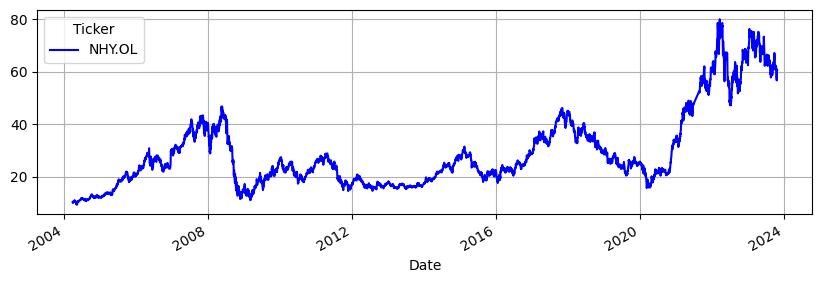

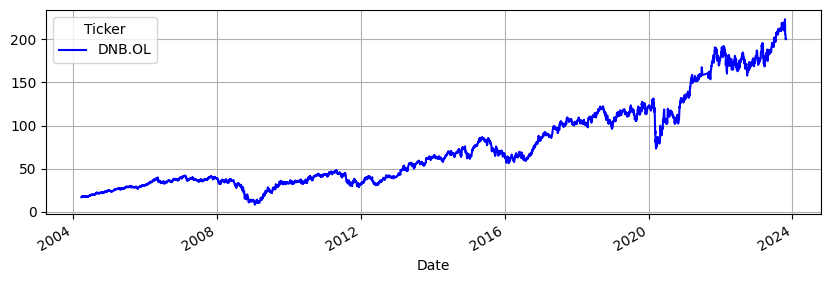

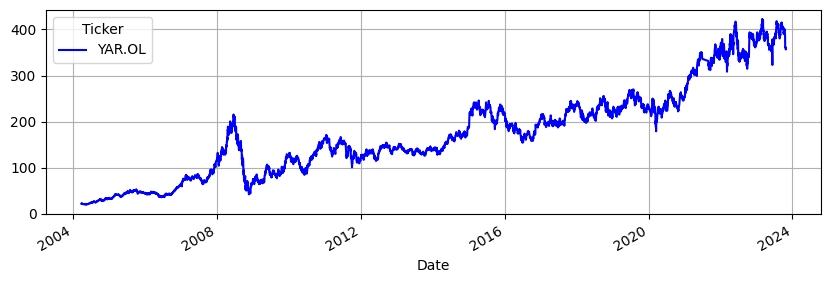

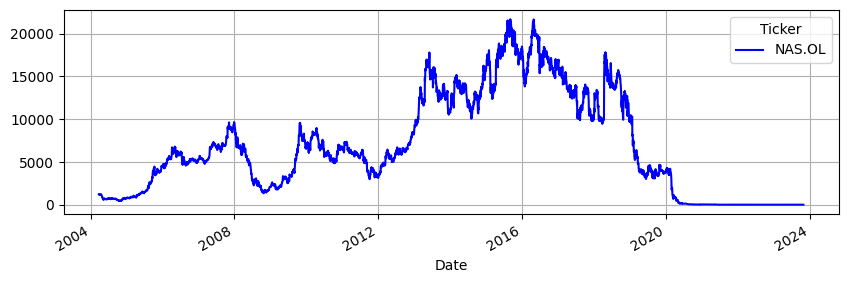

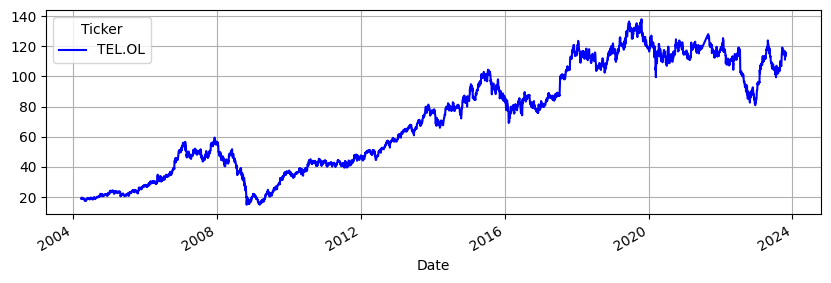

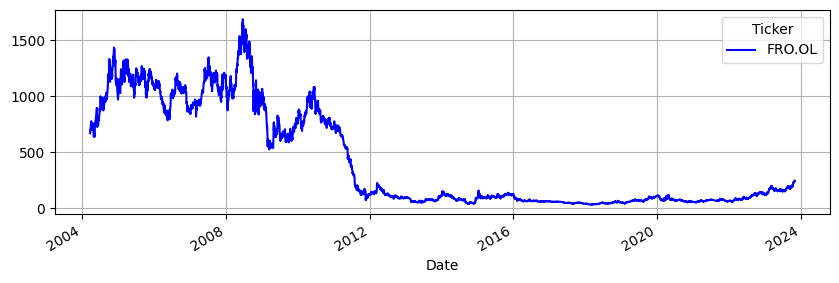

In [3]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [4]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-26 00:00:00+01:00,0.009112,0.002677,-0.014185,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.014185,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,0.004684,-0.008097,-0.055627,-0.014888
2004-03-31 00:00:00+02:00,0.022473,-0.002561,-0.018869,0.003478,0.008438,-0.004008
2004-04-01 00:00:00+02:00,-0.011174,0.042666,-0.014389,-0.005804,-0.004210,0.004008
...,...,...,...,...,...,...
2023-10-23 00:00:00+02:00,0.000000,0.008673,-0.004556,-0.021956,-0.013481,-0.000553
2023-10-24 00:00:00+02:00,-0.010247,0.019244,0.035878,0.050165,-0.007030,0.000830
2023-10-25 00:00:00+02:00,-0.019312,0.013671,-0.036386,0.004347,0.022238,-0.004156


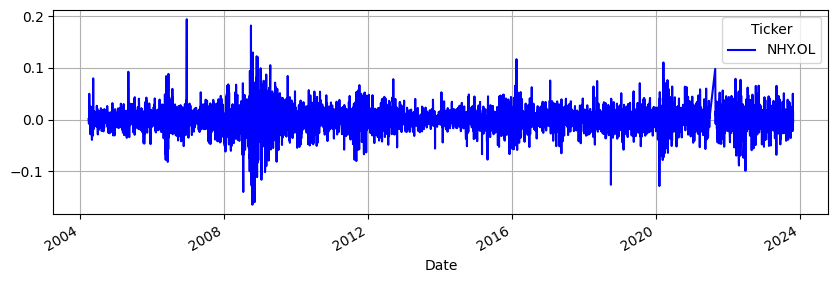

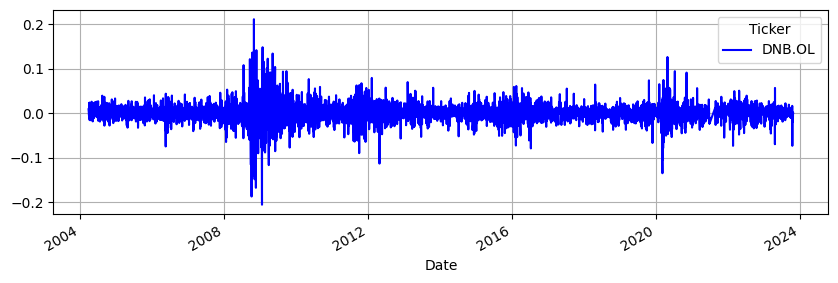

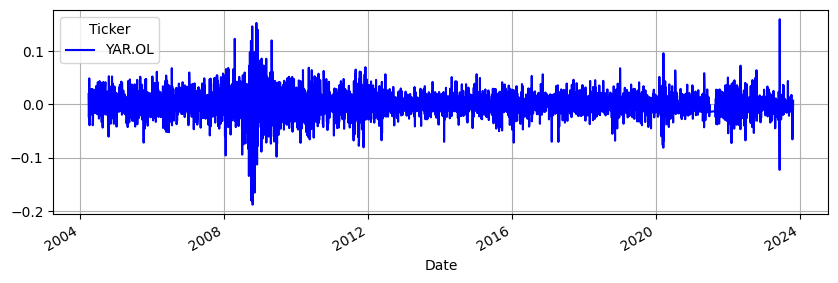

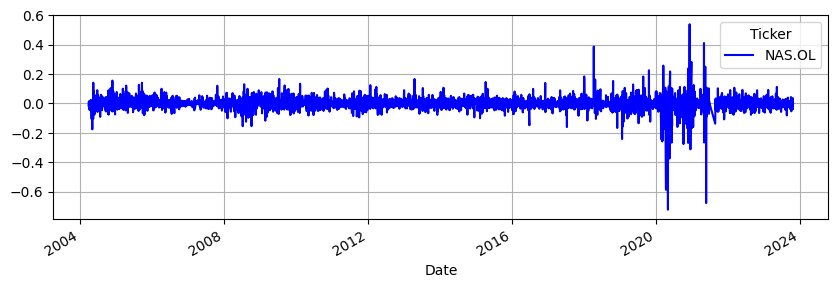

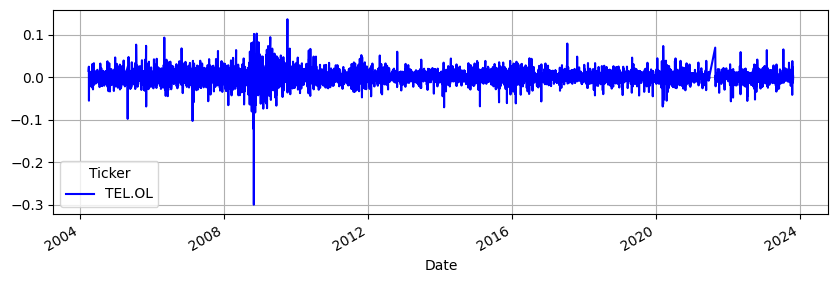

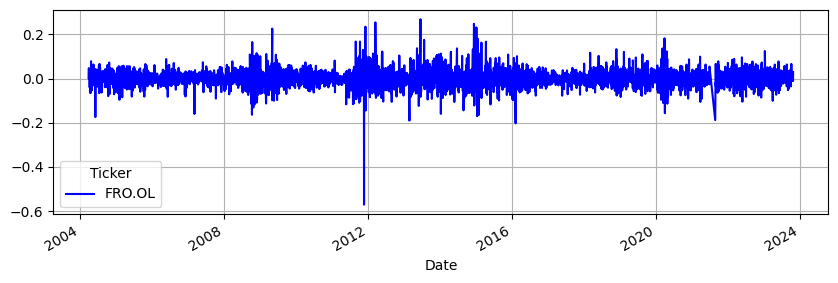

In [5]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [6]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,NAS.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.253422,0.194920,0.482605,0.388664,0.418182
FRO.OL,0.253422,1.000000,0.124735,0.315269,0.197058,0.277839
NAS.OL,0.194920,0.124735,1.000000,0.204137,0.152877,0.167200
NHY.OL,0.482605,0.315269,0.204137,1.000000,0.353360,0.487499
TEL.OL,0.388664,0.197058,0.152877,0.353360,1.000000,0.346859
YAR.OL,0.418182,0.277839,0.167200,0.487499,0.346859,1.000000


In [7]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.000000,1.000000,-0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,-0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
# The normalized ones are nearly orthogonal too
fit.norm_orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999463,0.087598,0.034682,0.022788,-0.012728,0.014254
1,0.087598,1.000319,0.050519,0.014672,-0.002609,0.019255
2,0.034682,0.050519,1.000164,-0.019033,0.037917,-0.049693
3,0.022788,0.014672,-0.019033,1.000851,0.031127,-0.009294
4,-0.012728,-0.002609,0.037917,0.031127,1.000489,0.066537
5,0.014254,0.019255,-0.049693,-0.009294,0.066537,1.000752


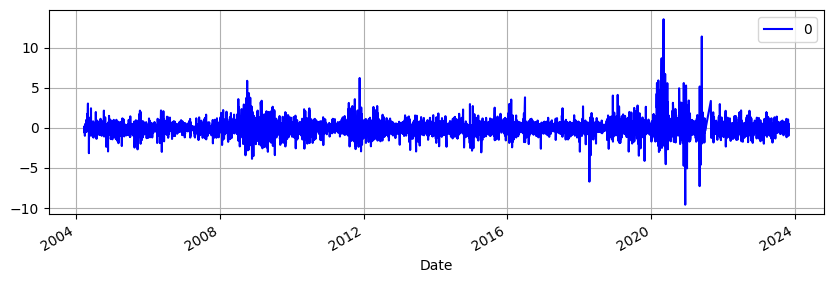

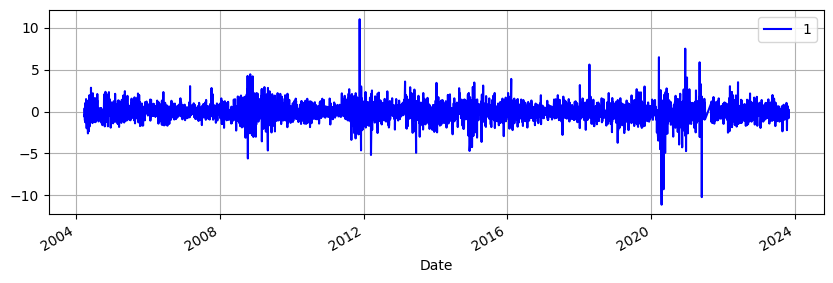

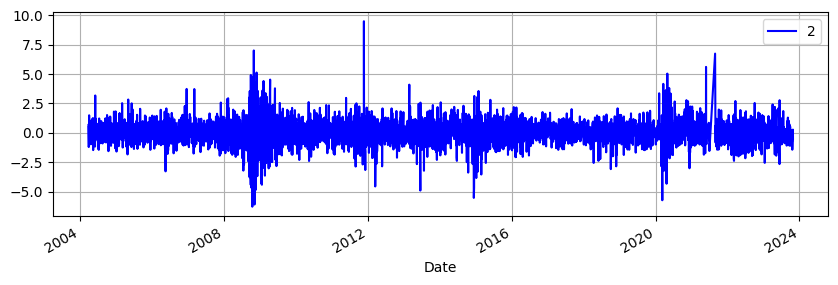

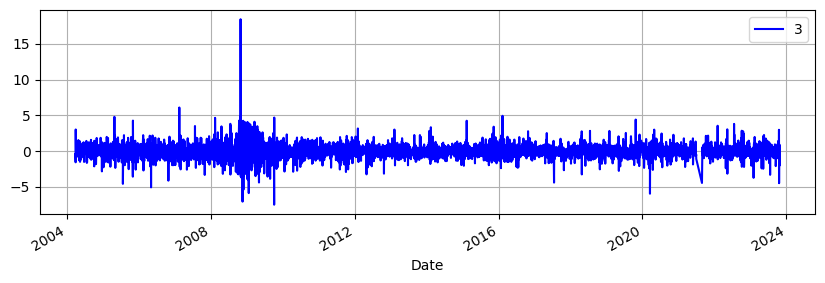

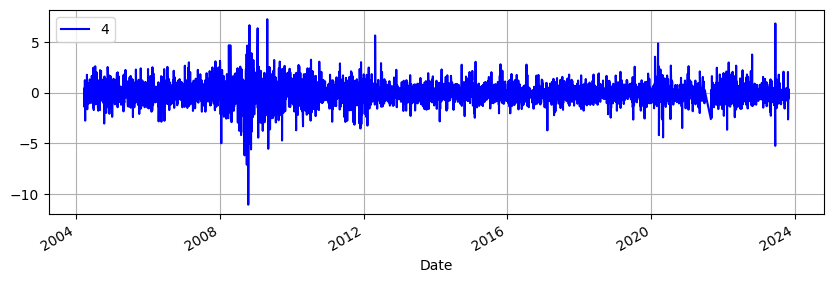

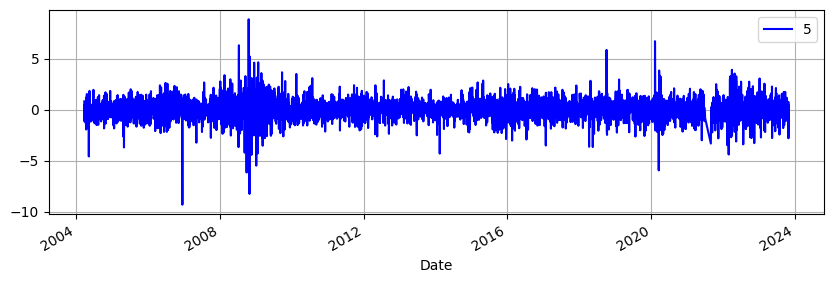

In [9]:
# Orthogonal disturbances
for col in fit.orthog_disturbances_df.columns:
    fit.orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

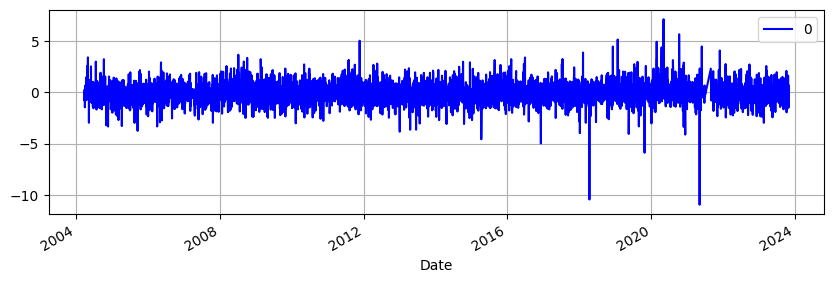

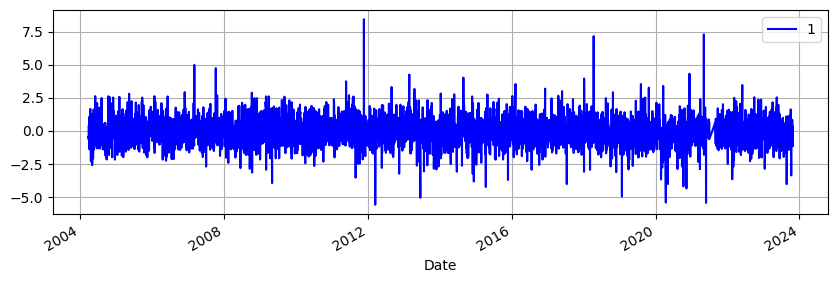

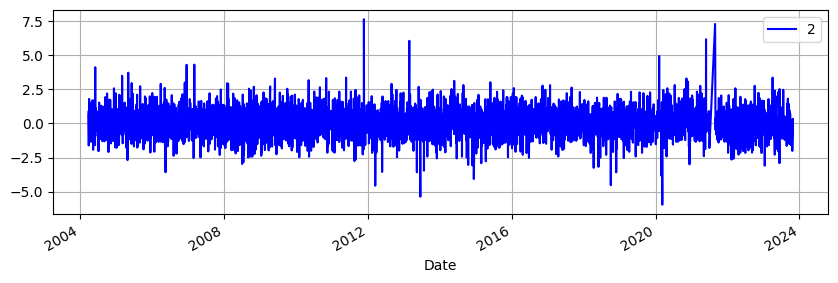

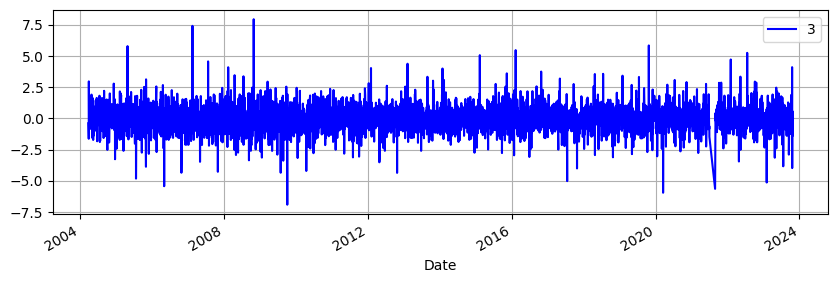

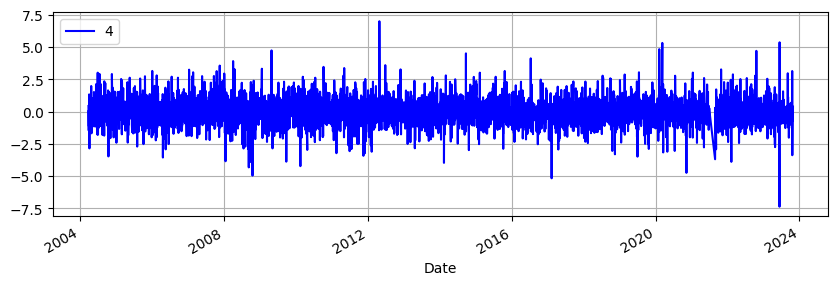

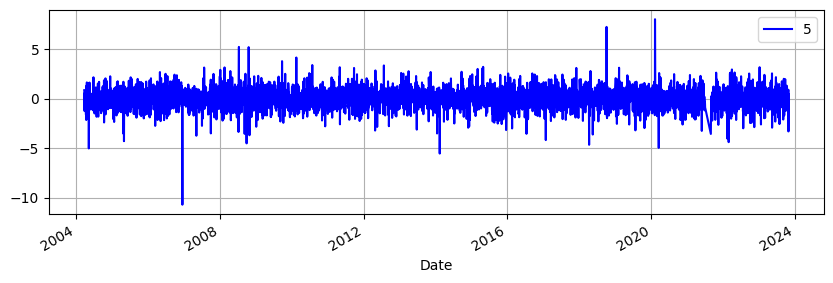

In [10]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for col in fit.orthog_disturbances_df.columns:
    fit.norm_orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

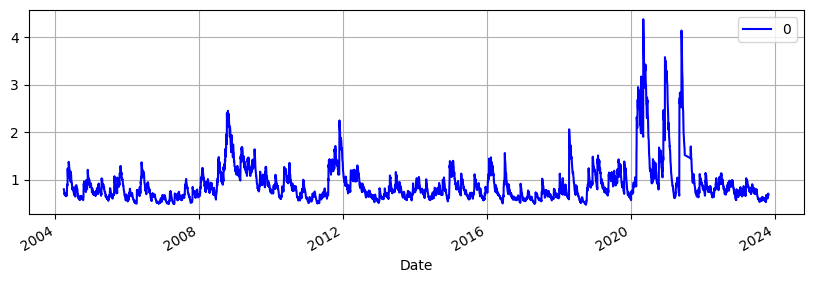

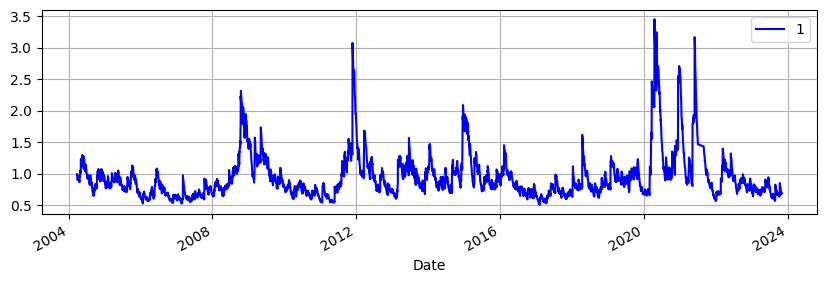

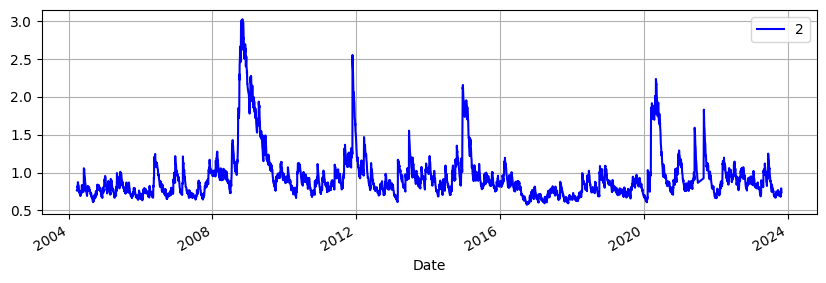

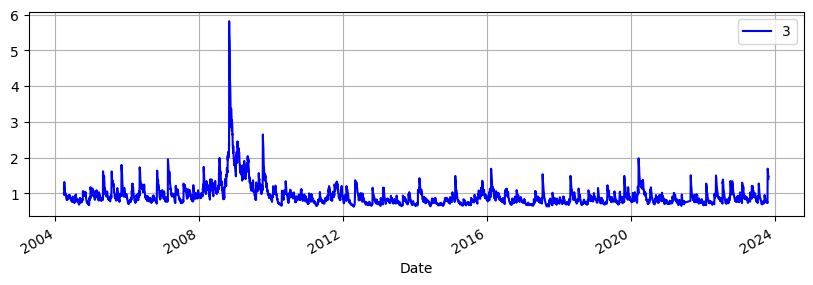

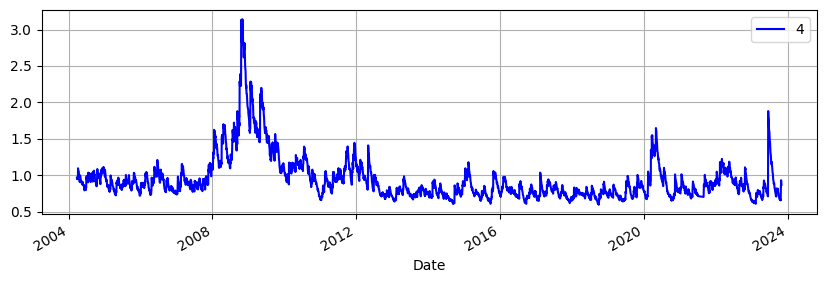

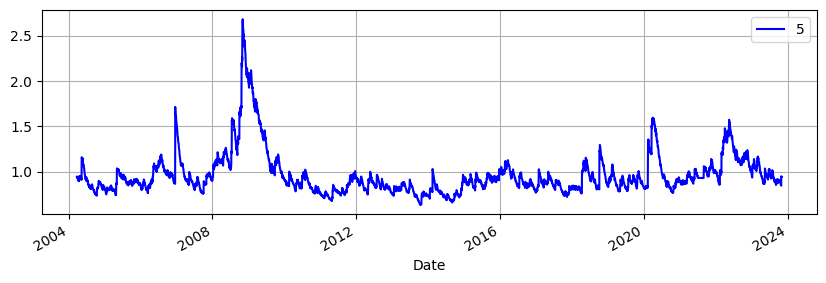

In [11]:
for col in fit.conditional_volatility_df.columns:
    fit.conditional_volatility_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

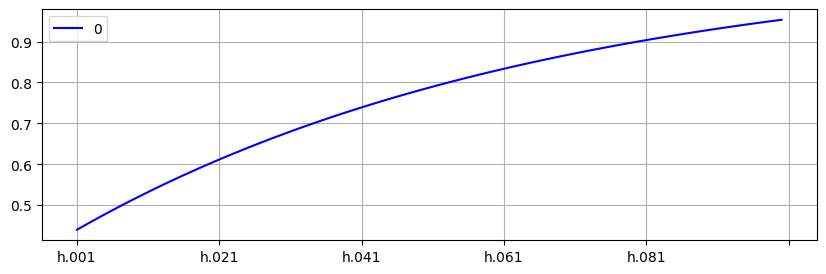

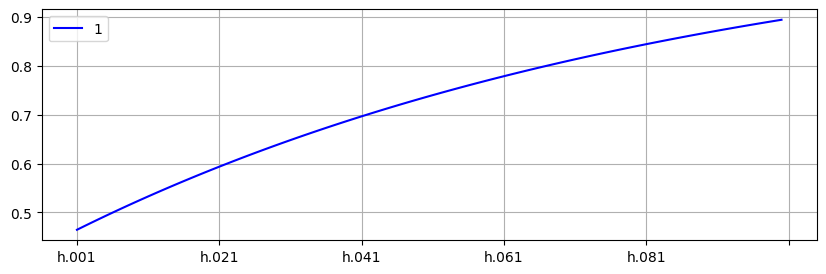

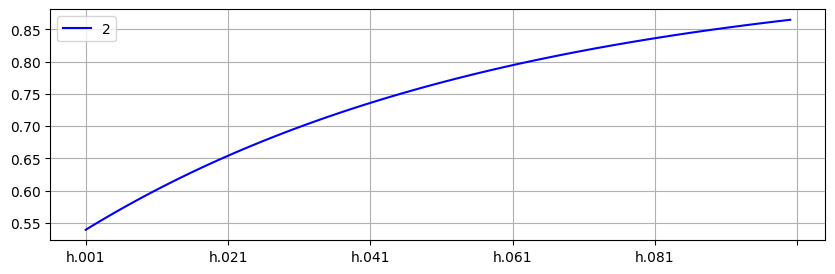

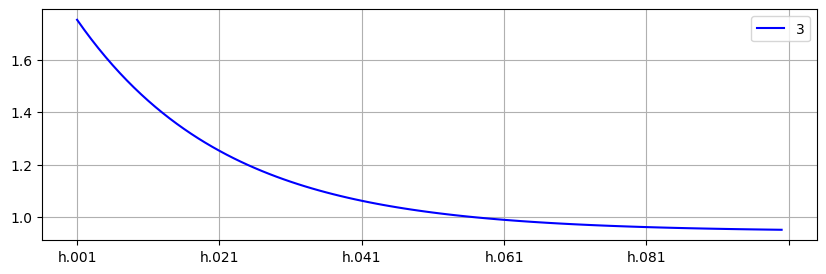

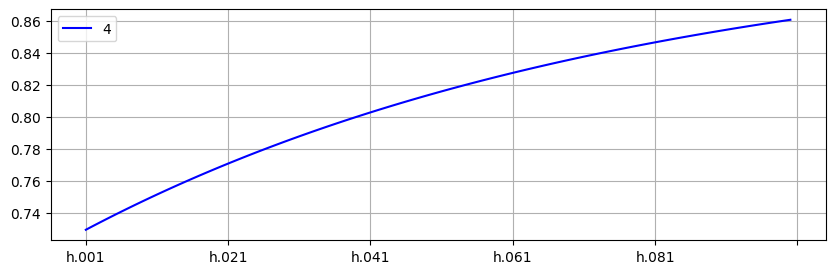

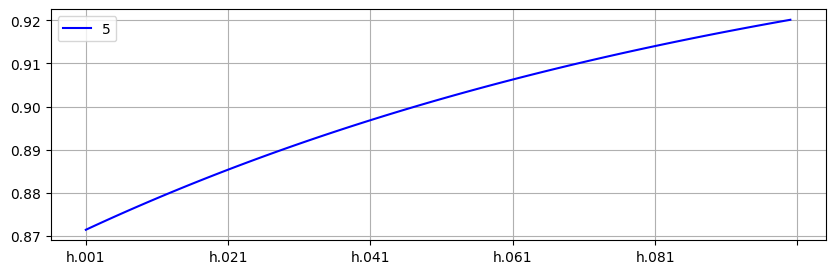

In [12]:
forecast_df = fit.forecast(100)
for col in forecast_df.columns:
    forecast_df[[col]].plot(color='b', figsize=(10, 3), grid=True)